In [6]:
import keras


In [7]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11005415997189139472
]


In [8]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [9]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


In [10]:
data_train = pd.read_csv('C:/Users/spcbe/Documents/GitHub/dataset/emergent_training_dataset.csv')
data_train

,emergent_page,claim,claim_description,claim_label,tags,claim_source_domain,claim_course_url,date,body,page_domain,page_url,page_headline,page_position,page_shares,page_order
0,http://www.emergent.info/disney-collector-is-f...,Claim: The woman behind the hugely popular DC ...,The channel has racked up more than 2.8 billio...,Unverified,"Daiane+DeJesus,DC+Toys+Collector,Porm,Sandy+Su...",dailymail.co.uk,http://www.dailymail.co.uk/news/article-295824...,2/25/2017,The Daily Mail published a story on Feb 24 tha...,dailymail.co.uk,http://www.dailymail.co.uk/news/article-295824...,Mystery woman behind the 'richest hands on the...,for,"4,982",1
1,http://www.emergent.info/disney-collector-is-f...,Claim: The woman behind the hugely popular DC ...,The channel has racked up more than 2.8 billio...,Unverified,"Daiane+DeJesus,DC+Toys+Collector,Porm,Sandy+Su...",dailymail.co.uk,http://www.dailymail.co.uk/news/article-295824...,2/25/2017,The Daily Mail published a story on Feb 24 tha...,nextshark.com,http://nextshark.com/revealed-woman-behind-5-m...,REVEALED: Woman Behind $5 Million Per Year You...,for,530,2
2,http://www.emergent.info/disney-collector-is-f...,Claim: The woman behind the hugely popular DC ...,The channel has racked up more than 2.8 billio...,Unverified,"Daiane+DeJesus,DC+Toys+Collector,Porm,Sandy+Su...",dailymail.co.uk,http://www.dailymail.co.uk/news/article-295824...,2/25/2017,The Daily Mail published a story on Feb 24 tha...,inquisitr.com,http://www.inquisitr.com/1870478/former-porn-s...,Former Porn Star Behind YouTube Sensation ‘DC ...,for,275,3
3,http://www.emergent.info/20-year-old-McDonalds...,Claim: Two Australian men kept a McDonald's Qu...,They say it's the world's oldest burger.,Unverified,"Australia,Food,Hamburger,McDonald's,Quarter+Po...",facebook.com,https://www.facebook.com/pages/Can-This-20-Yea...,2/17/2017,"Two friends,Casey Dean and Eduard Nitz, say th...",mirror.co.uk,http://www.mirror.co.uk/news/weird-news/worlds...,Is this the world's oldest burger? Man claims ...,observing,121,1
4,http://www.emergent.info/20-year-old-McDonalds...,Claim: Two Australian men kept a McDonald's Qu...,They say it's the world's oldest burger.,Unverified,"Australia,Food,Hamburger,McDonald's,Quarter+Po...",facebook.com,https://www.facebook.com/pages/Can-This-20-Yea...,2/17/2017,"Two friends,Casey Dean and Eduard Nitz, say th...",examiner.com,http://www.examiner.com/article/20-year-old-bu...,20-year-old burger: McDonald's Quarter Pounder...,for,54,2
5,http://www.emergent.info/20-year-old-McDonalds...,Claim: Two Australian men kept a McDonald's Qu...,They say it's the world's oldest burger.,Unverified,"Australia,Food,Hamburger,McDonald's,Quarter+Po...",facebook.com,https://www.facebook.com/pages/Can-This-20-Yea...,2/17/2017,"Two friends,Casey Dean and Eduard Nitz, say th...",newser.com,http://www.newser.com/story/202782/2-guys-reve...,20-Year-Old Quarter Pounder Looks About the Same,for,134,3
6,http://www.emergent.info/20-year-old-McDonalds...,Claim: Two Australian men kept a McDonald's Qu...,They say it's the world's oldest burger.,Unverified,"Australia,Food,Hamburger,McDonald's,Quarter+Po...",facebook.com,https://www.facebook.com/pages/Can-This-20-Yea...,2/17/2017,"Two friends,Casey Dean and Eduard Nitz, say th...",dailymail.co.uk,http://www.dailymail.co.uk/news/article-295569...,Would you take a bite out of the world's oldes...,for,73,4
7,http://www.emergent.info/20-year-old-McDonalds...,Claim: Two Australian men kept a McDonald's Qu...,They say it's the world's oldest burger.,Unverified,"Australia,Food,Hamburger,McDonald's,Quarter+Po...",facebook.com,https://www.facebook.com/pages/Can-This-20-Yea...,2/17/2017,"Two friends,Casey Dean and Eduard Nitz, say th...",9news.com.au,http://www.9news.com.au/national/2015/02/16/20...,Two blokes dared to eat 20-year-old burger for...,for,177,5
8,http://www.emergent.info/20-year-old-McDonalds...,Claim: Two Australian men kept a McDonald's Qu...,They say it's the world's oldest burger.,Unverif

In [12]:
# Input Data preprocessing
# data_train = pd.read_csv('C:/Users/spcbe/Documents/GitHub/Fake-News-Detection--master/dataset/train.csv')
#data_train['label'] = data_train['label'].replace('FAKE',1)
#data_train['label'] = data_train['label'].replace('REAL',0)
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
list_labels = list(set(data_train.claim_label))
texts = []
labels = []

for i in range(data_train.claim.shape[0]):
    text1 = str(data_train.claim_description[i])
    text = str(data_train.claim[i])
    texts.append(text+text1)
    labels.append(list_labels.index(data_train.claim_label[i]))
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['emergent_page', 'claim', 'claim_description', 'claim_label', 'tags',
       'claim_source_domain', 'claim_course_url', 'date', 'body',
       'page_domain', 'page_url', 'page_headline', 'page_position',
       'page_shares', 'page_order'],
      dtype='object')
What the raw input data looks like:
                                       emergent_page  \
0  http://www.emergent.info/disney-collector-is-f...   
1  http://www.emergent.info/disney-collector-is-f...   
2  http://www.emergent.info/disney-collector-is-f...   
3  http://www.emergent.info/20-year-old-McDonalds...   
4  http://www.emergent.info/20-year-old-McDonalds...   

                                               claim  \
0  Claim: The woman behind the hugely popular DC ...   
1  Claim: The woman behind the hugely popular DC ...   
2  Claim: The woman behind the hugely popular DC ...   
3  Claim: Two Australian men kept a McDonald's Qu...   
4  Claim: Two Australian men kept a McDonald's Qu...   

                    

In [13]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = len(list_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (2145, 1000)
Shape of label tensor: (2145, 3)


In [14]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
#x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
# print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 1716 429
real & fake news in train,valt,test:
[686. 595. 435.]
[171. 142. 116.]


In [15]:
#Using Pre-trained word embeddings
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'C:/Users/spcbe/Documents/GitHub/Fake-News-Detection--master/dataset/glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.


In [18]:
# CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(list_labels), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting the simple convolutional neural network model")
model.summary()
history = model.fit(x_train, y_train,
          epochs=3, batch_size=128)

Fitting the simple convolutional neural network model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         130700    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)     

dict_keys(['loss', 'acc'])


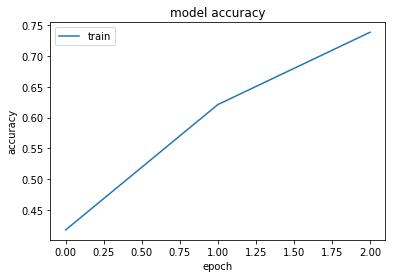

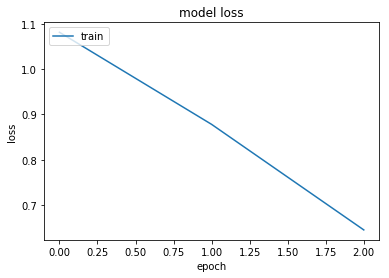

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# #convolutional approach
# convs = []
# filter_sizes = [3,4,5]

# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)

# for fsz in filter_sizes:
#     l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
#     l_pool = MaxPooling1D(5)(l_conv)
#     convs.append(l_pool)
    
# l_merge = Merge(mode='concat', concat_axis=1)(convs)
# l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
# l_pool1 = MaxPooling1D(5)(l_cov1)
# l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(30)(l_cov2)
# l_flat = Flatten()(l_pool2)
# l_dense = Dense(128, activation='relu')(l_flat)
# preds = Dense(2, activation='softmax')(l_dense)

# model2 = Model(sequence_input, preds)
# model2.compile(loss='categorical_crossentropy',
#               optimizer='adadelta',
#               metrics=['acc'])

# print("Fitting a more complex convolutional neural network model")
# model2.summary()
# history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
#           epochs=3, batch_size=50)
# model2.save('model.h5')

In [43]:
# # list all data in history
# print(history2.history.keys())
# import matplotlib.pyplot as plt
# %matplotlib inline 
# # summarize history for accuracy
# plt.plot(history2.history['acc'])
# #plt.plot(history2.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history2.history['loss'])
# #plt.plot(history2.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

Correct predictions: 379
Total number of test examples: 429
Accuracy of model1:  0.8834498834498834


Text(0.5, 0, 'predicted label')

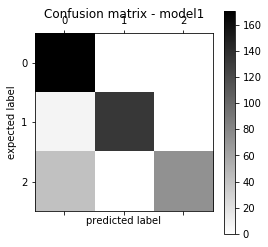

In [21]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
# correct_predictions = float(sum(test_preds == y_test)[0])
preds =[]
actual =[]
correct_predictions= 0
for i in range(len(test_preds)):
    y = np.argmax(y_test[i])
    x = np.argmax(test_preds[i])
    preds.append(x)
    actual.append(y)
#     x = a.index(1.0)
#     y = b.index(1.0)
    if x == y:
        correct_predictions+=1
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

# #Test model 2
# test_preds2 = model2.predict(x_test)
# test_preds2 = np.round(test_preds2)
# correct_predictions = float(sum(test_preds2 == y_test)[0])
# print("Correct predictions:", correct_predictions)
# print("Total number of test examples:", len(y_test))
# print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# # Creating the Confusion Matrix
# x_pred = model2.predict(x_test)
# x_pred = np.round(x_pred)
# x_pred = x_pred.argmax(1)
# y_test_s = y_test.argmax(1)
# cm = confusion_matrix(y_test_s, x_pred)
# plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest',)
# plt.title('Confusion matrix - model2')
# plt.colorbar()
# plt.ylabel('expected label')
# plt.xlabel('predicted label')
# plt.show()

In [25]:
print(preds.count(0) , preds.count(1) , preds.count(2) )

221 134 74


In [26]:
print(actual.count(0) , actual.count(1) , actual.count(2))

171 142 116


In [27]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2571481481229231
Test accuracy: 0.9207459208848593


In [26]:
# score = model2.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])